In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np

/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('data/data_processed.csv')

string_cols = ['survey_language', 'disability']
df[string_cols] = df[string_cols].astype('category')
df[string_cols] = df[string_cols].apply(lambda x: x.cat.codes)



In [3]:
TRANSPORT_MODES = ['drive', 'passenger', 'bus', 'subway', 'bike', 'walk', 'other']
candidate_cols = [
#      'travel_date_dow',
#      'o_purpose_category',
     'd_purpose_category',
     'num_non_hh_travelers',
#      'num_hh_travelers',
     'num_travelers',
#      'o_location_type',
#      'd_location_type',
     'o_congestion',
     'd_congestion',
#      'age',
#      'employment',
#      'student',
#      'license',
#      'planning_apps',
#      'industry',
#      'gender',
#      'education',
#      'survey_language',
#      'num_bicycles',
     'num_vehicles',
     'res_type',
#      'rent_own',
#      'income_aggregate',
#      'num_people',
#      'num_adults',
#      'num_kids',
#      'num_workers',
#      'num_students',
#      'disability'
#     'trip_distance'
]

categorial_columns = ['travel_date_dow',
       'o_purpose_category', 'd_purpose_category', 'o_location_type',
       'd_location_type', 'age', 'employment', 'license', 'planning_apps', 'industry', 'gender'
                    , 'survey_language',
       'res_type', 'rent_own',  'disability']

onehot = pd.get_dummies(df[candidate_cols], columns=[x for x in categorial_columns if x in candidate_cols])

X = onehot.to_numpy()
# y = df['trip_distance_category'].astype('category').cat.codes.to_numpy()
def mode_to_int(x):
    return TRANSPORT_MODES.index(x)

y = df['mode'].apply(mode_to_int)

group = df['person_id'].to_numpy()


XGBoost parameters: https://xgboost.readthedocs.io/en/stable/parameter.html

In [95]:
# param = {'objective': 'multi:softprob',
#          'num_class': 7, 
#          'eval_metric': ['mlogloss', 'merror']}

In [4]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, plot_confusion_matrix

import matplotlib.pyplot as plt
import matplotlib

def acc_pre_rec(y_true, y_pred, verbose=False):
    ''' Returns accuracy, precision, and recall together. 
    If verbose is set to True, it prints the scores for 
    each mode.'''
    acc = accuracy_score(y_true, y_pred)
    prec, rec, fsc, sup = precision_recall_fscore_support(
        y_true, y_pred)
    
    if verbose:
        print(f'Accuracy: \n    {acc*100:.3f}%')
        scrs = {'Precision': prec, 'Recall': rec}
        for k, v in scrs.items():
            str_ = '%;\n    '.join(
                f'{TRANSPORT_MODES[i]} - {100*s:.3f}'
                for i, s in enumerate(v)
            )
            print(f"{k}: \n    {str_}%")
    else:
        return acc, prec, rec


Accuracy: 
    57.663%
Precision: 
    drive - 60.609%;
    passenger - 29.048%;
    bus - 31.818%;
    subway - 51.461%;
    bike - 0.000%;
    walk - 58.695%;
    other - 17.857%
Recall: 
    drive - 77.991%;
    passenger - 8.266%;
    bus - 1.628%;
    subway - 23.320%;
    bike - 0.000%;
    walk - 77.169%;
    other - 10.274%
Cross entrophy loss 1.1333574812001286
----
Accuracy: 
    56.420%
Precision: 
    drive - 55.588%;
    passenger - 22.761%;
    bus - 15.789%;
    subway - 53.019%;
    bike - 0.000%;
    walk - 61.407%;
    other - 12.500%
Recall: 
    drive - 79.103%;
    passenger - 11.891%;
    bus - 2.679%;
    subway - 34.450%;
    bike - 0.000%;
    walk - 69.085%;
    other - 1.266%
Cross entrophy loss 1.2261590357193242
----
Accuracy: 
    55.584%
Precision: 
    drive - 62.333%;
    passenger - 22.427%;
    bus - 20.339%;
    subway - 45.134%;
    bike - 0.000%;
    walk - 57.187%;
    other - 3.922%
Recall: 
    drive - 71.205%;
    passenger - 13.957%;
    bus -

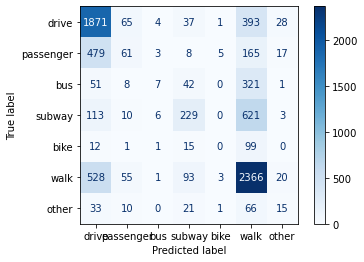

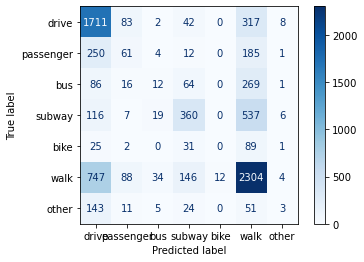

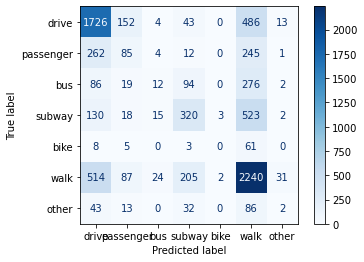

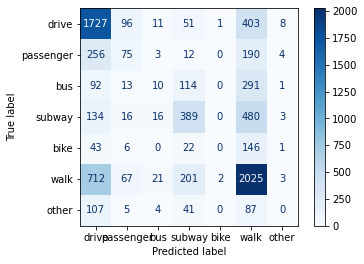

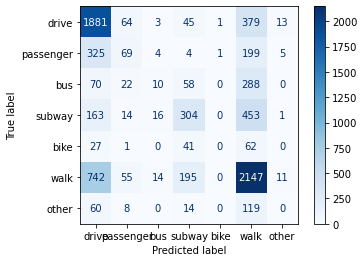

In [5]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, ConfusionMatrixDisplay, log_loss
from sklearn.tree import DecisionTreeRegressor



k_fold = GroupKFold(n_splits=5)


mse = [] # [(training_mse, validation_mse, variance)]
mae = [] # [(training_mae, validation_mae, mean_avearge_deviation)]

for train_idx, validate_idx in k_fold.split(X, y, groups=group):
    
    X_train, X_val = X[train_idx], X[validate_idx]
    y_train, y_val = y[train_idx], y[validate_idx]
    model = xgb.XGBClassifier(objective='multi:softprob',
                              n_estimators = 100,
                              n_jobs=-1,
                              num_class=7,
                              random_state=42,
                              eval_metric=['mlogloss', 'merror'],
                              use_label_encoder =False)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_prob_train = model.predict_proba(X_train)
    y_prob_val = model.predict_proba(X_val)
    
    acc_pre_rec(y_val, y_pred_val, True)
    
    print('Cross entrophy loss', log_loss(y_val, y_prob_val))
    
    
#     plot_confusion_matrix(model, X_val, y_val, values_format= 'd', cmap=plt.cm.Blues, display_labels=TRANSPORT_MODES)
    display = ConfusionMatrixDisplay.from_predictions(
        y_val,
        y_pred_val,
        display_labels=TRANSPORT_MODES,
        values_format= 'd', 
        cmap=plt.cm.Blues
    )
    print('----')
